In [ ]:
from src.utils.plotly_utils import imshow, line, scatter

2025-01-29 17:01:10.885667: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512_VNNI
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-29 17:01:11.089787: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [ ]:
#imports
from transformer_lens import HookedTransformer
import torch
from random import sample
import pandas as pd
import pickle
import os
import matplotlib.pyplot as plt

from src.vul_detect.diff_directions import *
from src.utils.logits_utils import find_bos_token
from src.utils.file_utils import load_files_named, filter_adv_org_samples

import numpy as np

DEVICE = "cuda:0"
save_folder = "work/outputs_vul"

In [ ]:
#model
model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-3.2-1B-Instruct",
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    #default_prepend_bos = False
    # refactor_factored_attn_matrices=True
)

Loaded pretrained model meta-llama/Llama-3.2-1B-Instruct into HookedTransformer


In [4]:
output_folder = 'work/outputs'
adv_samples = load_files_named(output_folder, file_starts_with='adv')
unique_tensor = filter_adv_samples(adv_samples)

Tensor shape with duplicates: torch.Size([474, 102])
Final tensor shape: torch.Size([311, 102])


In [5]:
df_names = pd.read_csv('data/wiki_last_name_master.csv')

In [6]:
adv_string = model.to_string(unique_tensor)
names = [prompt.split("ue\n    \" ")[-1].split(" wrote")[0] for prompt in adv_string]    
name_counts = pd.Series(names).value_counts()

# Merge with DataFrame to map names to regions
df = df_names.set_index("Localized Name")
df["name_count"] = name_counts

# Reset index and drop NaNs (for names not in the DataFrame)
df = df.reset_index().dropna(subset=["name_count"])

# Aggregate counts by region
region_counts = df.groupby("Sub_Region")["name_count"].sum()
print(region_counts)

Sub_Region
Central America    19.0
East Asia          30.0
Eastern Europe     19.0
Middle East        39.0
North America      19.0
Northern Europe    23.0
Oceania            18.0
South America      19.0
South Asia         80.0
Southeast Asia     38.0
Southern Europe    18.0
Western Europe     17.0
Name: name_count, dtype: float64


In [8]:
#FULL 
batch_size = 2
save_prefix = "full"

sampled_prompts_tokenized = unique_tensor
print(f'number of samples: {sampled_prompts_tokenized.shape[0]}')
position_of_eos = find_bos_token(sampled_prompts_tokenized, bos_token = 128009)

pos_slice = torch.tensor(position_of_eos).to(DEVICE)

toxicity = [0 for _ in range(sampled_prompts_tokenized.shape[0])]
y_sampled = np.array(toxicity) > 0.5

answer_tokens = ['true' if y else 'false' for y in y_sampled]
wrong_tokens = ['false' if y else 'true' for y in y_sampled]


answer_tokens = model.to_tokens(answer_tokens, prepend_bos=False)
wrong_tokens = model.to_tokens(wrong_tokens, prepend_bos=False)

get_heads_logit_diff(prompts = sampled_prompts_tokenized, 
                answer_tokens = answer_tokens, 
                wrong_tokens = wrong_tokens, 
                position_of_eos = pos_slice,
                model = model,
                batch_size = batch_size,
                save_folder = save_folder,
                save_prefix = save_prefix)

number of samples: 311
Tried to stack head results when they weren't cached. Computing head results now
Saved per_head_logit_diffs_0.pkl
Tried to stack head results when they weren't cached. Computing head results now
Saved per_head_logit_diffs_2.pkl
Tried to stack head results when they weren't cached. Computing head results now
Saved per_head_logit_diffs_4.pkl
Tried to stack head results when they weren't cached. Computing head results now
Saved per_head_logit_diffs_6.pkl
Tried to stack head results when they weren't cached. Computing head results now
Saved per_head_logit_diffs_8.pkl
Tried to stack head results when they weren't cached. Computing head results now
Saved per_head_logit_diffs_10.pkl
Tried to stack head results when they weren't cached. Computing head results now
Saved per_head_logit_diffs_12.pkl
Tried to stack head results when they weren't cached. Computing head results now
Saved per_head_logit_diffs_14.pkl
Tried to stack head results when they weren't cached. Computin

In [9]:
full_per_head_logit_diffs = []
for i in range(0,len(sampled_prompts_tokenized),batch_size):
    with open(f'{save_folder}/{save_prefix}_per_head_logit_diffs_{i}.pkl', 'rb') as f:
        heads_logit_diff = pickle.load(f)

    full_per_head_logit_diffs.append(heads_logit_diff)

mean_per_head_logit_diffs = torch.mean(torch.stack(full_per_head_logit_diffs), dim=0)

In [11]:
fig = imshow(
        mean_per_head_logit_diffs,
        labels={"x":"Head", "y":"Layer"},
        title=f"Logit Difference From Each Head for adversarial samples",
        width=600,
    return_fig = True
    )

fig.write_image("work/saved/bias/plot_vul_toxic.svg", format="svg")  # Save as SVG

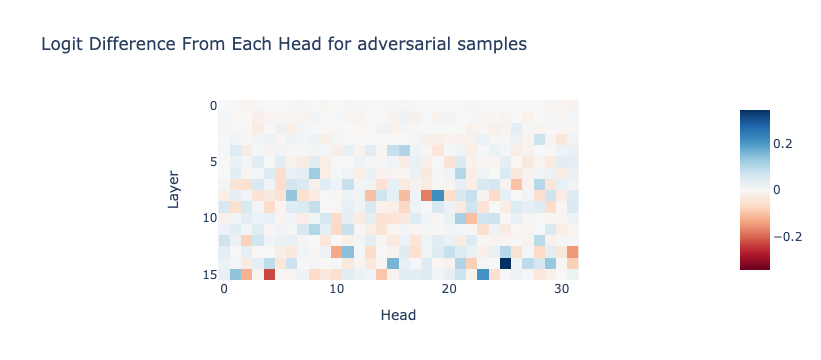

In [16]:
imshow(
        mean_per_head_logit_diffs,
        labels={"x":"Head", "y":"Layer"},
        title=f"Logit Difference From Each Head for adversarial samples",
        width=600
    )

In [ ]:
output_folder = 'work/outputs_vul'

full_per_head_logit_diffs = load_files_named(output_folder, file_starts_with='full', if_gpu=True)

mean_per_head_logit_diffs = torch.mean(torch.stack(full_per_head_logit_diffs), dim=0)

torch.save(mean_per_head_logit_diffs, f'work/saved/bias/vul_heads_og_method_bias.pth')